# OBB Augmentation with Affine Transform: Boats Example

This notebook demonstrates applying **Affine** transforms to **oriented bounding boxes (OBB)** using real boat imagery.

**Data:** `images/boats.webp` + `images/boats.json` (OBB annotations in pixel coords)

## Imports & Setup

In [ ]:
import json
import albumentations as A
import cv2
import numpy as np
from matplotlib import pyplot as plt
from pathlib import Path

%matplotlib inline

## Load Image & OBB Annotations

In [ ]:
DATA_DIR = Path("../images")
IMG_PATH = DATA_DIR / "boats.webp"
JSON_PATH = DATA_DIR / "boats.json"

with open(JSON_PATH) as f:
    data = json.load(f)

img = cv2.imread(str(IMG_PATH))
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

h, w = img.shape[:2]
img_h, img_w = data["image_height"], data["image_width"]

# boats.json: center_x, center_y, width, height, angle (pixels) = cxcywh format
def obbs_from_json(annos):
    obbs = [[o["center_x"], o["center_y"], o["width"], o["height"], o["angle"]] for o in annos]
    labels = [o.get("label", "boat") for o in annos]
    return obbs, labels

obbs, labels = obbs_from_json(data["bboxes_obb"])

print(f"Image: {img.shape}")
print(f"OBB count: {len(obbs)}")
print(f"Sample OBB (cxcywh pixels): {obbs[0]}")

Image: (682, 1024, 3)
OBB count: 50
Sample OBB (cxcywh pixels): [94.87516784667969, 35.12500762939453, 44.970943450927734, 138.50645446777344, -44.19306945800781]


## Visualization Utilities

In [ ]:
def visualize_obb(img, obb, color=(0, 255, 0), thickness=2, label=None, normalized=False):
    """Draw OBB on image. obb: [cx, cy, w, h, angle]. normalized=True => coords in [0,1], else pixels."""
    img = np.asarray(img).copy()
    h, w = img.shape[:2]
    if normalized:
        xc, yc = float(obb[0]) * w, float(obb[1]) * h
        bw, bh = float(obb[2]) * w, float(obb[3]) * h
    else:
        xc, yc = float(obb[0]), float(obb[1])
        bw, bh = float(obb[2]), float(obb[3])
    angle = float(obb[4])
    rect = ((xc, yc), (bw, bh), angle)
    box = cv2.boxPoints(rect)
    cv2.drawContours(img, [np.intp(box)], 0, color, thickness)
    cv2.circle(img, (int(xc), int(yc)), 4, color, -1)
    if label:
        cv2.putText(img, label, (int(xc) + 8, int(yc) - 8),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 1)
    return img


def visualize_obbs(img, obbs, labels=None, color=(0, 255, 0), thickness=2, normalized=False):
    """Draw all OBBs on image."""
    out = img.copy()
    for i, obb in enumerate(obbs):
        lbl = labels[i] if labels else None
        out = visualize_obb(out, obb, color=color, thickness=thickness, label=lbl, normalized=normalized)
    return out

## Original Image with OBBs

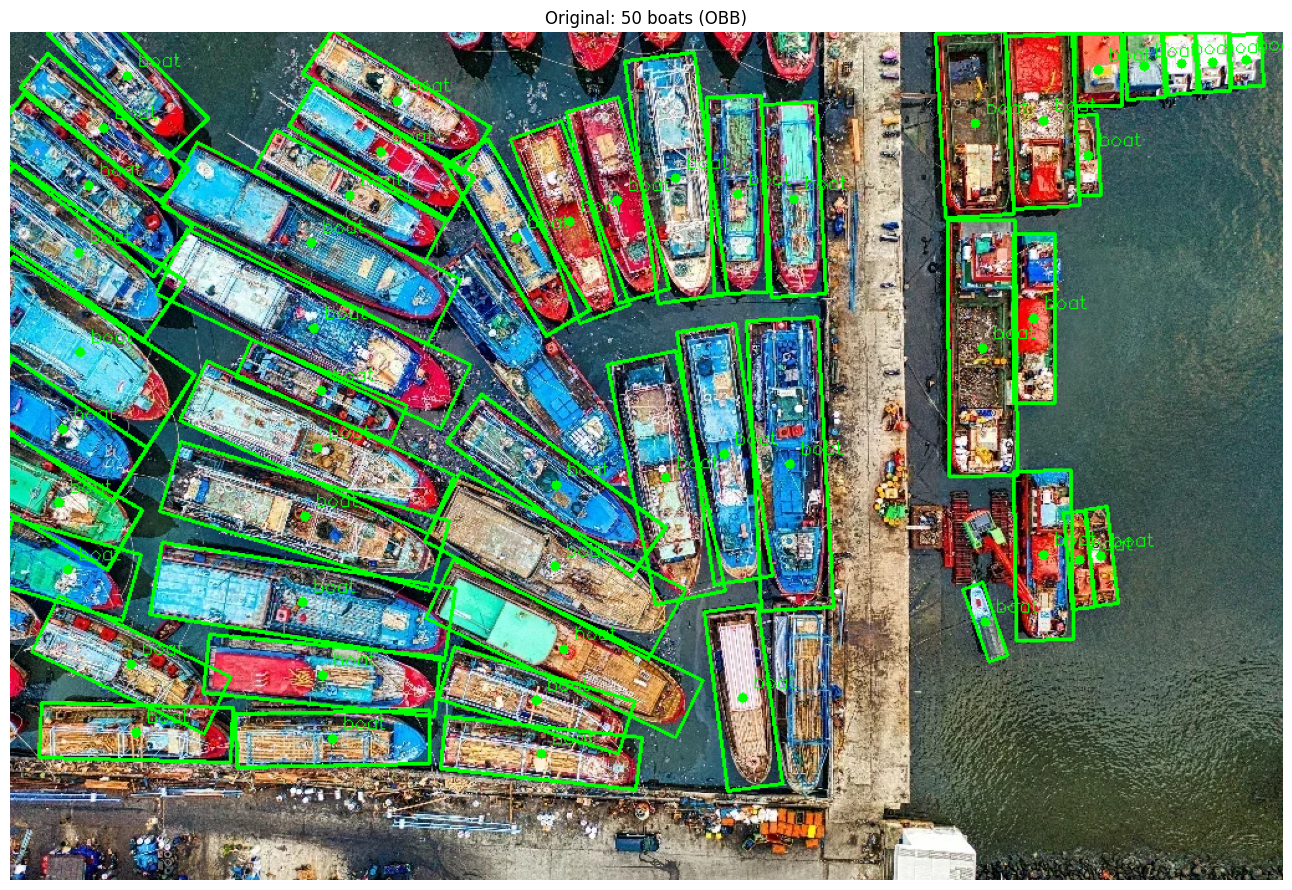

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(14, 9))
vis = visualize_obbs(img, obbs, labels, color=(0, 255, 0), thickness=2)
ax.imshow(vis)
ax.set_title(f"Original: {len(obbs)} boats (OBB)")
ax.axis("off")
plt.tight_layout()
plt.show()

## BboxParams for OBB

Key settings for OBB:
- `coord_format='cxcywh'`: [x_center, y_center, width, height] in pixels (requires albumentations 2.4+)
- `bbox_type='obb'`: 5th coord is angle
- `label_fields`: pass-through for class labels
- `min_visibility`: filter boxes with low visibility after transform

In [ ]:
bbox_params = A.BboxParams(
    coord_format="cxcywh",
    bbox_type="obb",
    label_fields=["labels"],
    min_visibility=0.1,
    min_area=0.0,
    clip_after_transform=False
)

## Affine Transform: Single Examples

Affine supports: **scale**, **translate** (percent or px), **rotate**, **shear**.

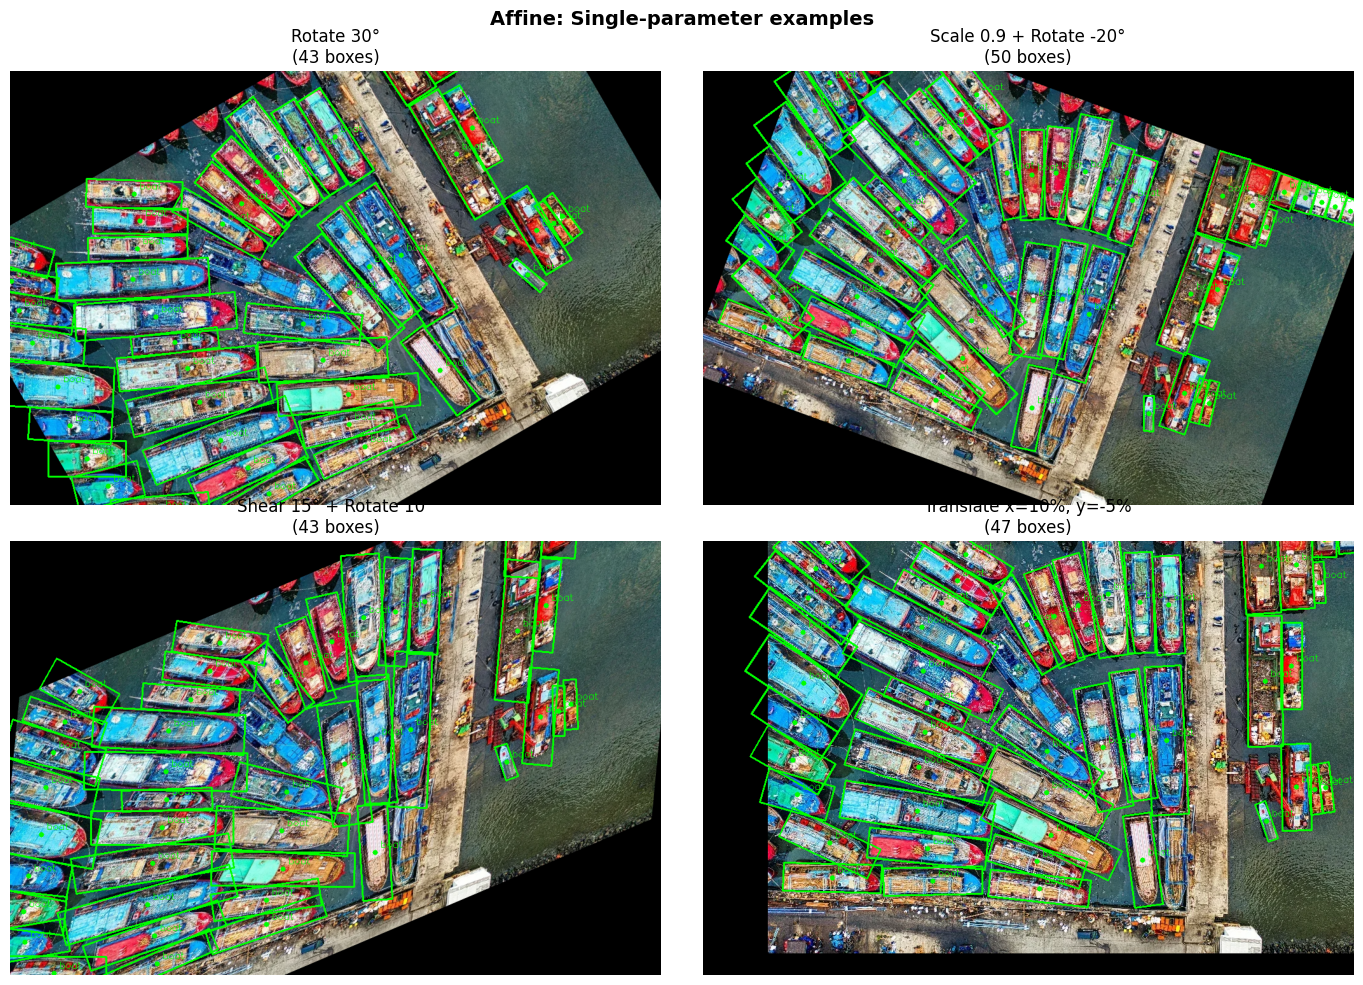

In [ ]:
# Rotation only
t_rotate = A.Compose(
    [A.Affine(rotate=30, p=1, border_mode=cv2.BORDER_CONSTANT)],
    bbox_params=bbox_params,
)

# Scale + rotate
t_scale_rotate = A.Compose(
    [A.Affine(scale=0.9, rotate=-20, p=1, border_mode=cv2.BORDER_CONSTANT)],
    bbox_params=bbox_params,
)

# Shear + rotate
t_shear = A.Compose(
    [A.Affine(shear=15, rotate=10, p=1, border_mode=cv2.BORDER_CONSTANT)],
    bbox_params=bbox_params,
)

# Translate
t_translate = A.Compose(
    [A.Affine(translate_percent={"x": 0.1, "y": -0.05}, p=1, border_mode=cv2.BORDER_CONSTANT)],
    bbox_params=bbox_params,
)

transforms = [
    ("Rotate 30°", t_rotate),
    ("Scale 0.9 + Rotate -20°", t_scale_rotate),
    ("Shear 15° + Rotate 10°", t_shear),
    ("Translate x=10%, y=-5%", t_translate),
]

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for ax, (name, t) in zip(axes, transforms):
    out = t(image=img, bboxes=obbs, labels=labels)
    aug_img = out["image"]
    aug_obbs = out["bboxes"]
    aug_labels = out["labels"]
    vis = visualize_obbs(aug_img, aug_obbs, aug_labels, color=(0, 255, 0), thickness=4)
    ax.imshow(vis)
    ax.set_title(f"{name}\n({len(aug_obbs)} boxes)")
    ax.axis("off")

plt.suptitle("Affine: Single-parameter examples", fontsize=14, fontweight="bold")
plt.tight_layout()
plt.show()

## Affine Grid: Varying Rotation

In [ ]:
angles = [-45, -15, 15, 45]
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for ax, angle in zip(axes, angles):
    t = A.Compose(
        [A.Affine(rotate=angle, p=1, border_mode=cv2.BORDER_CONSTANT)],
        bbox_params=bbox_params,
    )
    out = t(image=img, bboxes=obbs, labels=labels)
    vis = visualize_obbs(out["image"], out["bboxes"], out["labels"], color=(0, 255, 0), thickness=4)
    ax.imshow(vis)
    ax.set_title(f"Rotate {angle}° ({len(out['bboxes'])} boxes)")
    ax.axis("off")

plt.suptitle("Affine: Rotation grid", fontsize=14, fontweight="bold")
plt.tight_layout()
plt.show()


## Affine Grid: Scale × Rotation

In [ ]:
scales = [0.8, 1.0, 1.2]
rotations = [-30, 0, 30]

fig, axes = plt.subplots(len(scales), len(rotations), figsize=(12, 12))

for i, scale in enumerate(scales):
    for j, rot in enumerate(rotations):
        t = A.Compose(
            [A.Affine(scale=scale, rotate=rot, p=1, border_mode=cv2.BORDER_CONSTANT)],
            bbox_params=bbox_params,
        )
        out = t(image=img, bboxes=obbs, labels=labels)
        vis = visualize_obbs(out["image"], out["bboxes"], out["labels"], color=(0, 255, 0), thickness=4)
        axes[i, j].imshow(vis)
        axes[i, j].set_title(f"scale={scale}, rot={rot}°")
        axes[i, j].axis("off")

plt.suptitle("Affine: Scale × Rotation grid", fontsize=14, fontweight="bold")
plt.tight_layout()
plt.show()


## Affine Grid: Shear × Rotation

In [ ]:
shears = [-15, 0, 15]
rotations = [-20, 0, 20]

fig, axes = plt.subplots(len(shears), len(rotations), figsize=(12, 12))

for i, shear in enumerate(shears):
    for j, rot in enumerate(rotations):
        t = A.Compose(
            [A.Affine(shear=shear, rotate=rot, p=1, border_mode=cv2.BORDER_CONSTANT)],
            bbox_params=bbox_params,
        )
        out = t(image=img, bboxes=obbs, labels=labels)
        vis = visualize_obbs(out["image"], out["bboxes"], out["labels"], color=(0, 255, 0), thickness=4)
        axes[i, j].imshow(vis)
        axes[i, j].set_title(f"shear={shear}°, rot={rot}°")
        axes[i, j].axis("off")

plt.suptitle("Affine: Shear × Rotation grid", fontsize=14, fontweight="bold")
plt.tight_layout()
plt.show()


## Random Affine (Training-style)

In [ ]:
t_random = A.Compose(
    [
        A.Affine(
            scale=(0.85, 1.15),
            translate_percent={"x": (-0.1, 0.1), "y": (-0.1, 0.1)},
            rotate=(-30, 30),
            shear=(-10, 10),
            p=1,
            border_mode=cv2.BORDER_CONSTANT,
        )
    ],
    bbox_params=bbox_params,
)

fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = axes.flatten()

for ax in axes:
    out = t_random(image=img, bboxes=obbs, labels=labels)
    vis = visualize_obbs(out["image"], out["bboxes"], out["labels"], color=(0, 255, 0), thickness=2)
    ax.imshow(vis)
    ax.set_title(f"{len(out['bboxes'])} boxes")
    ax.axis("off")

plt.suptitle("Random Affine (training-style augmentation)", fontsize=14, fontweight="bold")
plt.tight_layout()
plt.show()


## Pipeline: Affine + Other Transforms

In [ ]:
pipeline = A.Compose(
    [
        A.Affine(scale=0.95, rotate=(-15, 15), shear=(-5, 5), p=0.9),
        A.HorizontalFlip(p=0.5),
        A.RandomBrightnessContrast(p=0.3),
    ],
    bbox_params=bbox_params,
)

fig, axes = plt.subplots(2, 3, figsize=(14, 9))
axes = axes.flatten()

for ax in axes:
    out = pipeline(image=img, bboxes=obbs, labels=labels)
    vis = visualize_obbs(out["image"], out["bboxes"], out["labels"], color=(0, 255, 0), thickness=2)
    ax.imshow(vis)
    ax.set_title(f"{len(out['bboxes'])} boxes")
    ax.axis("off")

plt.suptitle("Pipeline: Affine + HFlip + BrightnessContrast", fontsize=14, fontweight="bold")
plt.tight_layout()
plt.show()


## OBB Angle Verification

In [ ]:
obb0 = obbs[0]
print(f"Original OBB[0]: angle={obb0[4]:.1f}°")

t = A.Compose(
    [A.Affine(rotate=25, p=1, border_mode=cv2.BORDER_CONSTANT)],
    bbox_params=bbox_params,
)
out = t(image=img, bboxes=[obb0], labels=[labels[0]])
if out["bboxes"]:
    aug0 = out["bboxes"][0]
    print(f"After rotate=25°: angle={aug0[4]:.1f}°")
    print(f"Expected ~{obb0[4] + 25:.1f}° (additive)")
